In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from sodapy import Socrata
from shapely import wkt,MultiPolygon,Point,Polygon,MultiLineString,LineString
from datetime import datetime
sns.set_theme(style="whitegrid")
from shapely.ops import unary_union
import os
import pyodbc
crs="EPSG:4326"

# Load Calgary Community data

In [2]:
#get community data from data.calgary.ca using API
#data source: https://data.calgary.ca/Base-Maps/Community-District-Boundaries/surr-xmvs/about_data
client = Socrata("data.calgary.ca", None)
results = client.get("surr-xmvs",limit=500)
community_df = pd.DataFrame.from_records(results)

In [3]:
community_df.head()

,class,class_code,comm_code,name,sector,srg,comm_structure,multipolygon
0,Industrial,2,EFI,EASTFIELD,EAST,N/A,EMPLOYMENT,"{'type': 'MultiPolygon', 'coordinates': [[[[-1..."
1,Industrial,2,MLI,MAYLAND,NORTHEAST,N/A,EMPLOYMENT,"{'type': 'MultiPolygon', 'coordinates': [[[[-1..."
2,Residual Sub Area,4,09H,09H,EAST,N/A,UNDEVELOPED,"{'type': 'MultiPolygon', 'coordinates': [[[[-1..."
3,Residential,1,LEB,LEWISBURG,NORTH,DEVELOPING,BUILDING OUT,"{'type': 'MultiPolygon', 'coordinates': [[[[-1..."
4,Residual Sub Area,4,12B,12B,SOUTHEAST,FUTURE,UNDEVELOPED,"{'type': 'MultiPolygon', 'coordinates': [[[[-1..."


In [4]:
community_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   class           310 non-null    object
 1   class_code      310 non-null    object
 2   comm_code       310 non-null    object
 3   name            310 non-null    object
 4   sector          310 non-null    object
 5   srg             310 non-null    object
 6   comm_structure  308 non-null    object
 7   multipolygon    310 non-null    object
dtypes: object(8)
memory usage: 19.5+ KB


In [5]:
#drop unnecessary columns
community_df = community_df.drop(columns=['class_code','comm_code','srg','comm_structure'])

In [6]:
community_df.head()

,class,name,sector,multipolygon
0,Industrial,EASTFIELD,EAST,"{'type': 'MultiPolygon', 'coordinates': [[[[-1..."
1,Industrial,MAYLAND,NORTHEAST,"{'type': 'MultiPolygon', 'coordinates': [[[[-1..."
2,Residual Sub Area,09H,EAST,"{'type': 'MultiPolygon', 'coordinates': [[[[-1..."
3,Residential,LEWISBURG,NORTH,"{'type': 'MultiPolygon', 'coordinates': [[[[-1..."
4,Residual Sub Area,12B,SOUTHEAST,"{'type': 'MultiPolygon', 'coordinates': [[[[-1..."


In [7]:
#create geodataframe
community_df['geometry'] = community_df['multipolygon'].apply(lambda x: MultiPolygon(x['coordinates']))
community_df.drop(columns=['multipolygon'],inplace=True)  
community_df = gpd.GeoDataFrame(community_df, geometry='geometry', crs=crs)

In [8]:
#calculate the area of the community
community_df['area'] = community_df.to_crs("EPSG:32611")['geometry'].area/1000000

In [9]:
#create ID column for street_df dataset
community_df.sort_values(by='name',inplace=True,ascending=True)
community_df['id'] = range(1,len(community_df)+1)

In [10]:
community_df

,class,name,sector,geometry,area,id
194,Residual Sub Area,01B,NORTHWEST,"MULTIPOLYGON (((-114.23119 51.10689, -114.2337...",1.994519,1
266,Residual Sub Area,01C,WEST,"MULTIPOLYGON (((-114.23421 51.08146, -114.2284...",0.644227,2
34,Residual Sub Area,01F,NORTHWEST,"MULTIPOLYGON (((-114.26442 51.12310, -114.2644...",0.884257,3
302,Residual Sub Area,01H,WEST,"MULTIPOLYGON (((-114.27030 51.10060, -114.2703...",2.532254,4
298,Residual Sub Area,01I,WEST,"MULTIPOLYGON (((-114.25828 51.08155, -114.2690...",0.141949,5
...,...,...,...,...,...,...
210,Residential,WINSTON HEIGHTS/MOUNTVIEW,CENTRE,"MULTIPOLYGON (((-114.04746 51.08369, -114.0482...",3.015168,306
204,Residential,WOLF WILLOW,SOUTH,"MULTIPOLYGON (((-114.00527 50.87779, -114.0077...",2.861363,307
54,Residential,WOODBINE,SOUTH,"MULTIPOLYGON (((-114.11796 50.95054, -114.1193...",3.181666,308
27,Residential,WOODLANDS,SOUTH,"MULTIPOLYGON (((-114.11796 50.95054, -114.1180...",2.801365,309


# Load 4 quadrants and downtown spatial data:

In [11]:
#Calgary 4 quadrants data source: https://data.calgary.ca/Base-Maps/City-Quadrants/g2n2-qnvh/data_preview
#Calgary downtown: Redraw from https://www150.statcan.gc.ca/n1/pub/91f0015m/2021001/m-c/m-c-calgary-eng.pdf
cityquadrants_df = pd.read_csv("City_Quadrants_20231229.csv")
cityquadrants_df['Geometry']=cityquadrants_df['MULTIPOLYGON'].apply(wkt.loads)
cityquadrants_df = gpd.GeoDataFrame(cityquadrants_df,geometry='Geometry',crs=crs)
citydowntown_df = pd.read_csv("Downtown_polygon.csv")
citydowntown_df['Geometry'] = citydowntown_df['WKT'].apply(wkt.loads)
citydowntown_df = gpd.GeoDataFrame(citydowntown_df,geometry='Geometry',crs=crs)

In [12]:
cityquadrants_df

,QUADRANT,QUADRANT_STATUS,MULTIPOLYGON,Geometry
0,NE,Approved,"MULTIPOLYGON (((-114.062531 51.0530752, -114.0...","MULTIPOLYGON (((-114.06253 51.05308, -114.0622..."
1,SW,Approved,"MULTIPOLYGON (((-114.2622424 51.0885757, -114....","MULTIPOLYGON (((-114.26224 51.08858, -114.2644..."
2,NW,Approved,"MULTIPOLYGON (((-114.2923142 51.0886, -114.265...","MULTIPOLYGON (((-114.29231 51.08860, -114.2655..."
3,SE,Approved,"MULTIPOLYGON (((-113.948816 51.053078, -113.94...","MULTIPOLYGON (((-113.94882 51.05308, -113.9491..."


In [13]:
citydowntown_df

,WKT,id,Geometry
0,MULTIPOLYGON (((-114.094871720003 51.047792781...,Downtown,"MULTIPOLYGON (((-114.09487 51.04779, -114.0919..."


In [14]:
#drop unnecessary columns and rename columns
cityquadrants_df.drop(columns=['QUADRANT_STATUS','MULTIPOLYGON'],inplace=True)
cityquadrants_df.columns = ['Name','Geometry']

In [15]:
#drop unnecessary columns and rename columns
citydowntown_df.drop(columns='WKT',inplace=True)
citydowntown_df.columns = ['Name','Geometry']

<Axes: >

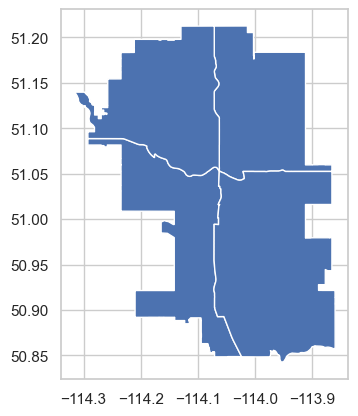

In [16]:
cityquadrants_df.plot()

<Axes: >

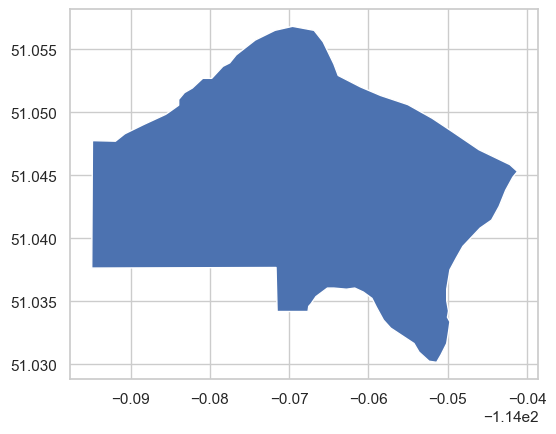

In [17]:
citydowntown_df.plot()

<Axes: >

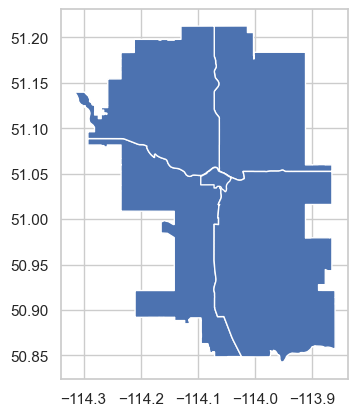

In [18]:
#combine 4 quadrants and downtown data:
quadrants_downtown_df = pd.concat([cityquadrants_df,citydowntown_df])
quadrants_downtown_df.plot()

In [19]:
#Calculate the area:
quadrants_downtown_df['area'] = quadrants_downtown_df.to_crs("EPSG:32611").geometry.area/1000000
quadrants_downtown_df

,Name,Geometry,area
0,NE,"MULTIPOLYGON (((-114.06253 51.05308, -114.0622...",177.002589
1,SW,"MULTIPOLYGON (((-114.26224 51.08858, -114.2644...",179.360849
2,NW,"MULTIPOLYGON (((-114.29231 51.08860, -114.2655...",199.125848
3,SE,"MULTIPOLYGON (((-113.94882 51.05308, -113.9491...",293.089259
0,Downtown,"MULTIPOLYGON (((-114.09487 51.04779, -114.0919...",6.111029


# Load street centreline data

In [20]:
#Data source: https://data.calgary.ca/Transportation-Transit/Street-Centreline/4dx8-rtm5/data_preview
street_df = pd.read_csv("Street_centreline.csv")
street_df['geometry']=street_df['WKT'].apply(wkt.loads)
street_df = gpd.GeoDataFrame(street_df,geometry='geometry',crs=crs)
street_df.drop(columns=['WKT'],inplace=True)
street_df

,FULL_NAME,ONE_WAY,NAME,STREET_TYPE,OCTANT,CTP_CLASS,geometry
0,LAIRD CO SW,B,LAIRD,CO,SW,Residential Street,"MULTIPOLYGON (((-114.12351 50.99324, -114.1235..."
1,TUSCANY SPRINGS LD NW,B,TUSCANY SPRINGS,LD,NW,Residential Street,"MULTIPOLYGON (((-114.24726 51.13465, -114.2472..."
2,100 WOODHAVEN BA SW,B,WOODHAVEN,BA,SW,Residential Street,"MULTIPOLYGON (((-114.13362 50.93502, -114.1336..."
3,NORSEMAN PL NW,B,NORSEMAN,PL,NW,Residential Street,"MULTIPOLYGON (((-114.08850 51.10282, -114.0884..."
4,WHITEHAVEN CR NE,B,WHITEHAVEN,CR,NE,Residential Street,"MULTIPOLYGON (((-113.97653 51.09324, -113.9749..."
...,...,...,...,...,...,...,...
10210,LAKE WATERTON CR SE,B,LAKE WATERTON,CR,SE,Residential Street,"MULTIPOLYGON (((-114.04707 50.94493, -114.0470..."
10211,400 GEORGIAN VI NE,B,GEORGIAN,VI,NE,Residential Street,"MULTIPOLYGON (((-113.94431 51.06273, -113.9447..."
10212,WENTWORTH MR SW,B,WENTWORTH,MR,SW,Residential Street,"MULTIPOLYGON (((-114.21497 51.05523, -114.2148..."
10213,200 SUNMOUNT BA SE,B,SUNMOUNT,BA,SE,Residential Street,"MULTIPOLYGON (((-114.03399 50.90619, -114.0343..."


In [21]:
#drop na by fullname
street_df.dropna(subset='FULL_NAME',inplace=True)

In [22]:
#create ID column for street_df dataset
street_df.sort_values(by='FULL_NAME',inplace=True,ascending=True)
street_df['id'] = range(1,len(street_df)+1)
street_df

,FULL_NAME,ONE_WAY,NAME,STREET_TYPE,OCTANT,CTP_CLASS,geometry,id
3061,1 AV NE,B,1,AV,NE,Residential Street,"MULTIPOLYGON (((-114.05135 51.05335, -114.0502...",1
3068,1 AV NW,B,1,AV,NW,Residential Street,"MULTIPOLYGON (((-114.07601 51.05797, -114.0762...",2
2801,1 AV SE,B,1,AV,SE,Residential Street,"MULTIPOLYGON (((-113.86617 51.05188, -113.8654...",3
2807,1 AV SW,B,1,AV,SW,Residential Street,"MULTIPOLYGON (((-114.07642 51.05222, -114.0769...",4
2996,1 ST E,FT,1,ST,E,Skeletal Road,"MULTIPOLYGON (((-114.06904 51.17419, -114.0691...",5
...,...,...,...,...,...,...,...,...
10100,YPRES GR SW,B,YPRES,GR,SW,Residential Street,"MULTIPOLYGON (((-114.11669 51.01704, -114.1166...",10210
7053,YPRES LN SW,B,YPRES,LN,SW,Residential Street,"MULTIPOLYGON (((-114.11730 51.01900, -114.1172...",10211
8470,YPRES ME SW,B,YPRES,ME,SW,Residential Street,"MULTIPOLYGON (((-114.11472 51.01883, -114.1151...",10212
3389,YPRES WY SW,B,YPRES,WY,SW,Residential Street,"MULTIPOLYGON (((-114.11543 51.01820, -114.1154...",10213


# Load Weather Data

In [23]:
#get file names from folder
files = os.listdir("weather_data")
for file in files:
    print(file)

en_climate_daily_AB_3031092_2019_P1D.csv
en_climate_daily_AB_3031092_2020_P1D.csv
en_climate_daily_AB_3031092_2021_P1D.csv
en_climate_daily_AB_3031092_2022_P1D.csv
en_climate_daily_AB_3031092_2023_P1D.csv


In [24]:
#read and combine csv files to 1 dataframe
weather_df = pd.DataFrame()
for file in files:
    weather_df = pd.concat([weather_df,pd.read_csv("weather_data/"+file)])

In [25]:
weather_df.head()

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
0,-114.01,51.12,CALGARY INTL A,3031092,2019-01-01,2019,1,1,NaN,5.9,...,0.0,NaN,0.0,NaN,4.0,NaN,28.0,NaN,50.0,NaN
1,-114.01,51.12,CALGARY INTL A,3031092,2019-01-02,2019,1,2,NaN,11.1,...,0.0,NaN,0.0,NaN,3.0,NaN,27.0,NaN,72.0,NaN
2,-114.01,51.12,CALGARY INTL A,3031092,2019-01-03,2019,1,3,NaN,9.7,...,0.0,NaN,0.0,NaN,0.0,T,27.0,NaN,65.0,NaN
3,-114.01,51.12,CALGARY INTL A,3031092,2019-01-04,2019,1,4,NaN,9.4,...,0.0,NaN,0.0,NaN,0.0,T,22.0,NaN,74.0,NaN
4,-114.01,51.12,CALGARY INTL A,3031092,2019-01-05,2019,1,5,NaN,-4.5,...,0.0,NaN,0.0,NaN,0.0,T,NaN,M,NaN,M


In [26]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1826 entries, 0 to 364
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Longitude (x)              1826 non-null   float64
 1   Latitude (y)               1826 non-null   float64
 2   Station Name               1826 non-null   object 
 3   Climate ID                 1826 non-null   int64  
 4   Date/Time                  1826 non-null   object 
 5   Year                       1826 non-null   int64  
 6   Month                      1826 non-null   int64  
 7   Day                        1826 non-null   int64  
 8   Data Quality               0 non-null      float64
 9   Max Temp (°C)              1777 non-null   float64
 10  Max Temp Flag              49 non-null     object 
 11  Min Temp (°C)              1777 non-null   float64
 12  Min Temp Flag              49 non-null     object 
 13  Mean Temp (°C)             1777 non-null   float64
 14

In [27]:
#drop unnecessary columns:
weather_df = weather_df[['Date/Time','Max Temp (°C)','Min Temp (°C)','Mean Temp (°C)','Total Rain (mm)','Total Snow (cm)']]

In [28]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1826 entries, 0 to 364
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date/Time        1826 non-null   object 
 1   Max Temp (°C)    1777 non-null   float64
 2   Min Temp (°C)    1777 non-null   float64
 3   Mean Temp (°C)   1777 non-null   float64
 4   Total Rain (mm)  1776 non-null   float64
 5   Total Snow (cm)  1778 non-null   float64
dtypes: float64(5), object(1)
memory usage: 99.9+ KB


In [29]:
weather_df.columns = ['Date','Max_temp','Min_temp','Mean_temp','Total_rain','Total_snow']

In [30]:
#fill missing value by mean of the previous date and post date:
for column in weather_df.columns[1:]:
    weather_df[column] = weather_df[column].fillna((weather_df[column].shift() + weather_df[column].shift(-1)) / 2)

In [31]:
weather_df= weather_df.fillna(0)

In [32]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1826 entries, 0 to 364
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1826 non-null   object 
 1   Max_temp    1826 non-null   float64
 2   Min_temp    1826 non-null   float64
 3   Mean_temp   1826 non-null   float64
 4   Total_rain  1826 non-null   float64
 5   Total_snow  1826 non-null   float64
dtypes: float64(5), object(1)
memory usage: 99.9+ KB


In [33]:
#convert to DateTime format
weather_df['Date'] = weather_df['Date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))

In [34]:
weather_df.head()

,Date,Max_temp,Min_temp,Mean_temp,Total_rain,Total_snow
0,2019-01-01,5.9,-11.6,-2.9,0.0,0.0
1,2019-01-02,11.1,4.9,8.0,0.0,0.0
2,2019-01-03,9.7,-0.6,4.6,0.0,0.0
3,2019-01-04,9.4,-6.2,1.6,0.0,0.0
4,2019-01-05,-4.5,-9.5,-7.0,0.0,0.0


# Create Date Table

In [35]:
start_date = '2019-01-01'
end_date = '2023-12-31'
date_range = pd.date_range(start=start_date, end=end_date)

# Create a DataFrame for the date table
date_table = pd.DataFrame({'Date': date_range})

# Add additional columns to the date table
date_table['Year'] = date_table['Date'].dt.year
date_table['Month'] = date_table['Date'].dt.month
date_table['Day'] = date_table['Date'].dt.day
date_table['Weekday'] = date_table['Date'].dt.day_name()
date_table['isweekend'] = date_table['Date'].apply(lambda x: 1 if x.weekday()>4 else 0)

In [36]:
date_table

,Date,Year,Month,Day,Weekday,isweekend
0,2019-01-01,2019,1,1,Tuesday,0
1,2019-01-02,2019,1,2,Wednesday,0
2,2019-01-03,2019,1,3,Thursday,0
3,2019-01-04,2019,1,4,Friday,0
4,2019-01-05,2019,1,5,Saturday,1
...,...,...,...,...,...,...
1821,2023-12-27,2023,12,27,Wednesday,0
1822,2023-12-28,2023,12,28,Thursday,0
1823,2023-12-29,2023,12,29,Friday,0
1824,2023-12-30,2023,12,30,Saturday,1


# Load Traffic incidents data

In [37]:
#get incident data from data.calgary.ca using API
#dat source: https://data.calgary.ca/Transportation-Transit/Traffic-Incidents/35ra-9556/about_data
client = Socrata("data.calgary.ca", None)
results = client.get("35ra-9556",limit=100000)
incident_df = pd.DataFrame.from_records(results)

In [38]:
incident_df.head()

,incident_info,description,start_dt,modified_dt,quadrant,longitude,latitude,count,id,point,:@computed_region_kxmf_bzkv,:@computed_region_4a3i_ccfj,:@computed_region_4b54_tmc4
0,Macleod Trail and 42 Avenue SE,Two vehicle incident. Blocking the WB right lane,2024-02-13T21:24:42.000,2024-02-13T21:27:36.000,NW,-114.06428395456986,51.01600856042104,1,2024-02-13T21:24:4251.01600856042104-114.06428...,"{'type': 'Point', 'coordinates': [-114.0642839...",160,3,10
1,Airport Road NE,Traffic incident.,2024-02-13T21:21:51.000,2024-02-13T21:27:36.000,NE,-114.01080182929414,51.131643200237285,1,2024-02-13T21:21:5151.131643200237285-114.0108...,"{'type': 'Point', 'coordinates': [-114.0108018...",86,4,11
2,Westwinds Crescent and Castleridge Blvd NE,Traffic incident.,2024-02-13T20:14:21.000,2024-02-13T21:02:31.000,NE,-113.96980077297708,51.1055640616455,1,2024-02-13T20:14:2151.1055640616455-113.969800...,"{'type': 'Point', 'coordinates': [-113.9698007...",119,4,9
3,Shaganappi Trail and Country Hills Boulevard NW,Two vehicle incident. Blocking multi lanes,2024-02-13T19:52:04.000,2024-02-13T20:16:57.000,NW,-114.1262057229771,51.14443369122683,1,2024-02-13T19:52:0451.14443369122683-114.12620...,"{'type': 'Point', 'coordinates': [-114.1262057...",25,2,2
4,58 Avenue and 4 Street SE,Traffic incident.,2024-02-13T18:58:50.000,2024-02-13T19:52:56.000,NW,-114.05386116535655,51.00135993292098,1,2024-02-13T18:58:5051.00135993292098-114.05386...,"{'type': 'Point', 'coordinates': [-114.0538611...",160,3,10


In [39]:
#drop necessary columns
incident_df.drop([':@computed_region_kxmf_bzkv',
                  ":@computed_region_4a3i_ccfj",
                  ":@computed_region_4b54_tmc4",
                  "count",
                  "point",
                  "id",
                  "modified_dt"
                 ],
                axis=1,inplace=True)

In [40]:
#convert pandas DataFrame to GeoDataFrame

incident_df = gpd.GeoDataFrame(incident_df, geometry=gpd.points_from_xy(incident_df.longitude, incident_df.latitude), crs=crs)

In [41]:
incident_df.head()

,incident_info,description,start_dt,quadrant,longitude,latitude,geometry
0,Macleod Trail and 42 Avenue SE,Two vehicle incident. Blocking the WB right lane,2024-02-13T21:24:42.000,NW,-114.06428395456986,51.01600856042104,POINT (-114.06428 51.01601)
1,Airport Road NE,Traffic incident.,2024-02-13T21:21:51.000,NE,-114.01080182929414,51.131643200237285,POINT (-114.01080 51.13164)
2,Westwinds Crescent and Castleridge Blvd NE,Traffic incident.,2024-02-13T20:14:21.000,NE,-113.96980077297708,51.1055640616455,POINT (-113.96980 51.10556)
3,Shaganappi Trail and Country Hills Boulevard NW,Two vehicle incident. Blocking multi lanes,2024-02-13T19:52:04.000,NW,-114.1262057229771,51.14443369122683,POINT (-114.12621 51.14443)
4,58 Avenue and 4 Street SE,Traffic incident.,2024-02-13T18:58:50.000,NW,-114.05386116535655,51.00135993292098,POINT (-114.05386 51.00136)


In [42]:
incident_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 45352 entries, 0 to 45351
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   incident_info  45352 non-null  object  
 1   description    45351 non-null  object  
 2   start_dt       45352 non-null  object  
 3   quadrant       31293 non-null  object  
 4   longitude      45352 non-null  object  
 5   latitude       45352 non-null  object  
 6   geometry       45352 non-null  geometry
dtypes: geometry(1), object(6)
memory usage: 2.4+ MB


In [43]:
#convert start_dt column to datatime
incident_df['start_dt'] = incident_df['start_dt'].apply(lambda x: datetime.strptime(x,'%Y-%m-%dT%H:%M:%S.%f'))

In [44]:
#filter data from 2019-2023
incident_df = incident_df[incident_df["start_dt"].apply(lambda x: datetime.strftime(x,"%Y")).isin(['2019','2020','2021',
                                                                                                   '2022','2023'])]

In [45]:
#create ID column from 1
incident_df.sort_values(by='start_dt',inplace=True,ascending=True)
incident_df['id'] = range(1,len(incident_df)+1)

In [46]:
#get hour from start_dt column
incident_df['hour'] = incident_df['start_dt'].apply(lambda x: datetime.strftime(x,"%H"))
incident_df['date']=incident_df['start_dt'].dt.date

In [47]:
#Create function to extract words in description column: provide a list of words (lst) check if  each word inside list is contained in words and return them
def check_word(words,lst):
    contained_words = []
    for i in lst:
        if i in words:
            contained_words.append(i)
    if len(contained_words)==0:
        return  None
    else:
        return ','.join(contained_words)

In [48]:
#lower description prepare for get other columns
incident_df['description'] = incident_df['description'].apply(lambda x: str(x).lower())
#check if incidents happended in the left, right or middle lane
incident_df['direction'] = incident_df.description.apply(lambda x: check_word(x,['left','right','middle']))
incident_df['direction'].value_counts()

direction
right           8209
left            4358
middle           328
left,right       230
left,middle        8
right,middle       6
Name: count, dtype: int64

In [49]:
#check if there is 1,2 or multi vehicle in the incidents, or there was stalled vehicle.
incident_df['no_of_vehicle'] = incident_df.description.apply(lambda x: check_word(x,['multi-vehicle','two vehicle','single vehicle','stalled vehicle']))
incident_df['no_of_vehicle'].value_counts()

no_of_vehicle
two vehicle        7948
multi-vehicle      2770
single vehicle     1775
stalled vehicle    1444
Name: count, dtype: int64

In [50]:
#check if there were pedestians or cylists involved in the incidents
incident_df['invole_pedestrian_cyclist'] = incident_df.description.apply(lambda x: check_word(x,['pedestrian','cyclist']))
incident_df['invole_pedestrian_cyclist'].value_counts()

invole_pedestrian_cyclist
pedestrian    1123
cyclist        347
Name: count, dtype: int64

In [51]:
incident_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 32199 entries, 33195 to 997
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   incident_info              32199 non-null  object        
 1   description                32199 non-null  object        
 2   start_dt                   32199 non-null  datetime64[ns]
 3   quadrant                   18142 non-null  object        
 4   longitude                  32199 non-null  object        
 5   latitude                   32199 non-null  object        
 6   geometry                   32199 non-null  geometry      
 7   id                         32199 non-null  int64         
 8   hour                       32199 non-null  object        
 9   date                       32199 non-null  object        
 10  direction                  13139 non-null  object        
 11  no_of_vehicle              13937 non-null  object        
 12 

In [52]:
#Join incident df with community df to get id community:
incident_df = gpd.sjoin(
                        incident_df,
                        community_df,
                        how='left',
                        predicate='intersects')

In [53]:
incident_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 32222 entries, 33195 to 997
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   incident_info              32222 non-null  object        
 1   description                32222 non-null  object        
 2   start_dt                   32222 non-null  datetime64[ns]
 3   quadrant                   18149 non-null  object        
 4   longitude                  32222 non-null  object        
 5   latitude                   32222 non-null  object        
 6   geometry                   32222 non-null  geometry      
 7   id_left                    32222 non-null  int64         
 8   hour                       32222 non-null  object        
 9   date                       32222 non-null  object        
 10  direction                  13141 non-null  object        
 11  no_of_vehicle              13942 non-null  object        
 12 

In [54]:
#drop unnecessary columns
incident_df.drop(columns=['index_right','class','name','sector','area'],inplace=True)
incident_df.drop_duplicates(subset=['id_left'],inplace=True)

In [55]:
incident_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 32199 entries, 33195 to 997
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   incident_info              32199 non-null  object        
 1   description                32199 non-null  object        
 2   start_dt                   32199 non-null  datetime64[ns]
 3   quadrant                   18142 non-null  object        
 4   longitude                  32199 non-null  object        
 5   latitude                   32199 non-null  object        
 6   geometry                   32199 non-null  geometry      
 7   id_left                    32199 non-null  int64         
 8   hour                       32199 non-null  object        
 9   date                       32199 non-null  object        
 10  direction                  13139 non-null  object        
 11  no_of_vehicle              13937 non-null  object        
 12 

In [56]:
#Join incident data with street data to get street id:
_join = gpd.sjoin(
                    incident_df,
                    street_df,
                    how='left',
                    predicate='intersects')

In [57]:
_join

,incident_info,description,start_dt,quadrant,longitude,latitude,geometry,id_left,hour,date,...,invole_pedestrian_cyclist,id_right,index_right,FULL_NAME,ONE_WAY,NAME,STREET_TYPE,OCTANT,CTP_CLASS,id
33195,Mcknight Boulevard and Centre Street N,single vehicle incident. the road is closed in...,2019-01-01 00:26:00,NW,-114.0624656,51.09619018,POINT (-114.06247 51.09619),1,00,2019-01-01,...,None,285.0,396.0,CENTRE ST N,B,CENTRE,ST,N,Collector,3631.0
33194,Mcknight Boulevard and Centre Street N,there is an incident involving a pedestrian. ...,2019-01-01 00:26:00,NW,-114.0624275,51.09610336,POINT (-114.06243 51.09610),2,00,2019-01-01,...,pedestrian,285.0,4748.0,MCKNIGHT BV NE,FT,MCKNIGHT,BV,NE,Skeletal Road,6842.0
33194,Mcknight Boulevard and Centre Street N,there is an incident involving a pedestrian. ...,2019-01-01 00:26:00,NW,-114.0624275,51.09610336,POINT (-114.06243 51.09610),2,00,2019-01-01,...,pedestrian,285.0,396.0,CENTRE ST N,B,CENTRE,ST,N,Collector,3631.0
33193,Eastbound Memorial Drive approaching Deerfoot ...,two vehicle incident. blocking the right lane,2019-01-01 00:38:00,SE,-114.0191624,51.04774448,POINT (-114.01916 51.04774),3,00,2019-01-01,...,None,68.0,1597.0,MEMORIAL DR NE,FT,MEMORIAL,DR,NE,Skeletal Road,6857.0
33192,Shawnee Gate and James Mckevitt Road SW,there is an incident involving a pedestrian.,2019-01-01 11:15:00,SW,-114.0751332,50.9214025,POINT (-114.07513 50.92140),4,11,2019-01-01,...,pedestrian,251.0,642.0,MILLRISE BV SW,FT,MILLRISE,BV,SW,Arterial Street,6928.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,Memorial Drive and Penbrooke Drive SE,traffic incident.,2023-12-31 18:20:44,SE,-113.94183839940851,51.0520679494735,POINT (-113.94184 51.05207),32196,18,2023-12-31,...,None,216.0,7577.0,PENBROOKE DR SE,B,PENBROOKE,DR,SE,Collector,7446.0
999,17 Avenue and 84 Street SE,traffic incident.,2023-12-31 19:12:06,SE,-113.90768550476453,51.03793082299435,POINT (-113.90769 51.03793),32197,19,2023-12-31,...,None,63.0,9196.0,17 AV SE,FT,17,AV,SE,Arterial Street,774.0
998,Southbound Deerfoot Trail and Stoney Trail,traffic incident. blocking the right lane,2023-12-31 23:26:20,NE,-114.00171899461783,51.18381234081133,POINT (-114.00172 51.18381),32198,23,2023-12-31,...,None,NaN,9698.0,DEERFOOT TR NE,FT,DEERFOOT,TR,NE,Skeletal Road,4635.0
997,5 Avenue and 2 Street SW,traffic signals are flashing red. crew has bee...,2023-12-31 23:28:38,NW,-114.06777747269663,51.048536459320964,POINT (-114.06778 51.04854),32199,23,2023-12-31,...,None,109.0,6006.0,2 ST SW,B,2,ST,SW,Collector,822.0


In [58]:
_join = pd.DataFrame(_join.groupby(['id_left'])['id'].agg(list)).reset_index()
incident_df = pd.merge(incident_df,_join,on='id_left')

In [59]:
incident_df['id'] = incident_df['id'].astype(str)

In [60]:
#Join incident data with dowtown map to get the incidents insde downtown:
incident_df = gpd.sjoin(
                        incident_df,
                        citydowntown_df,
                        how='left',
                        predicate='intersects')
incident_df=incident_df.fillna({"Name":0})
incident_df['is_downtown'] = incident_df['Name'].apply(lambda x: 0 if x==0 else 1) #check if the incidents happended in downtown or not
incident_df.drop(columns=['Name','index_right'],inplace=True)

In [61]:
incident_df.rename(columns={"id_left":"id","id_right":"community_id",'id':'street_ids'},inplace=True)

In [62]:
incident_df.head()

,incident_info,description,start_dt,quadrant,longitude,latitude,geometry,id,hour,date,direction,no_of_vehicle,invole_pedestrian_cyclist,community_id,street_ids,is_downtown
0,Mcknight Boulevard and Centre Street N,single vehicle incident. the road is closed in...,2019-01-01 00:26:00,NW,-114.0624656,51.09619018,POINT (-114.06247 51.09619),1,00,2019-01-01,None,single vehicle,None,285.0,[3631.0],0
1,Mcknight Boulevard and Centre Street N,there is an incident involving a pedestrian. ...,2019-01-01 00:26:00,NW,-114.0624275,51.09610336,POINT (-114.06243 51.09610),2,00,2019-01-01,None,None,pedestrian,285.0,"[6842.0, 3631.0]",0
2,Eastbound Memorial Drive approaching Deerfoot ...,two vehicle incident. blocking the right lane,2019-01-01 00:38:00,SE,-114.0191624,51.04774448,POINT (-114.01916 51.04774),3,00,2019-01-01,right,two vehicle,None,68.0,[6857.0],0
3,Shawnee Gate and James Mckevitt Road SW,there is an incident involving a pedestrian.,2019-01-01 11:15:00,SW,-114.0751332,50.9214025,POINT (-114.07513 50.92140),4,11,2019-01-01,None,None,pedestrian,251.0,"[6928.0, 8517.0, 6029.0]",0
4,Westbound 64 Avenue and Deerfoot Trail NE,two vehicle incident. blocking the right lane,2019-01-01 12:33:00,NE,-114.0492326,51.11065211,POINT (-114.04923 51.11065),5,12,2019-01-01,right,two vehicle,None,161.0,"[2335.0, 4635.0]",0


In [63]:
incident_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 32199 entries, 0 to 32198
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   incident_info              32199 non-null  object        
 1   description                32199 non-null  object        
 2   start_dt                   32199 non-null  datetime64[ns]
 3   quadrant                   18142 non-null  object        
 4   longitude                  32199 non-null  object        
 5   latitude                   32199 non-null  object        
 6   geometry                   32199 non-null  geometry      
 7   id                         32199 non-null  int64         
 8   hour                       32199 non-null  object        
 9   date                       32199 non-null  object        
 10  direction                  13139 non-null  object        
 11  no_of_vehicle              13937 non-null  object        
 12  i

In [64]:
#Since we have only 18142 values for quadrant column, I join incidents data with 4 quadrants map to get more data about four quadrants:
incident_df = gpd.sjoin(
                        incident_df,
                        cityquadrants_df,
                        how='left',
                        predicate='intersects')

In [65]:
incident_df.info() #we get 32083 quadrant value after join

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 32199 entries, 0 to 32198
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   incident_info              32199 non-null  object        
 1   description                32199 non-null  object        
 2   start_dt                   32199 non-null  datetime64[ns]
 3   quadrant                   18142 non-null  object        
 4   longitude                  32199 non-null  object        
 5   latitude                   32199 non-null  object        
 6   geometry                   32199 non-null  geometry      
 7   id                         32199 non-null  int64         
 8   hour                       32199 non-null  object        
 9   date                       32199 non-null  object        
 10  direction                  13139 non-null  object        
 11  no_of_vehicle              13937 non-null  object        
 12  i

In [66]:
#if the quadrant column is null, use the value from Name column
incident_df['quadrant'] = incident_df['quadrant'].fillna(incident_df['Name']) 

In [67]:
#drop unnecessary column
incident_df.drop(columns=['index_right','Name'],inplace=True)

In [68]:
#fill na in community_id and quadrant column, make sure that these coulumns don't contain null value
incident_df['community_id'].fillna(0,inplace=True)
incident_df['quadrant'].fillna("unknown",inplace=True)
#conver community_id column to integer value
incident_df['community_id'] = incident_df['community_id'].astype(int)

In [69]:
incident_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 32199 entries, 0 to 32198
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   incident_info              32199 non-null  object        
 1   description                32199 non-null  object        
 2   start_dt                   32199 non-null  datetime64[ns]
 3   quadrant                   32199 non-null  object        
 4   longitude                  32199 non-null  object        
 5   latitude                   32199 non-null  object        
 6   geometry                   32199 non-null  geometry      
 7   id                         32199 non-null  int64         
 8   hour                       32199 non-null  object        
 9   date                       32199 non-null  object        
 10  direction                  13139 non-null  object        
 11  no_of_vehicle              13937 non-null  object        
 12  i

# Convert to Pandas DataFrame before loading to SQL

In [70]:
#drop geometry and covert to Pandas DataFrame
quadrants_downtown_df = pd.DataFrame(quadrants_downtown_df.drop(columns='Geometry'))

In [71]:
#create "unknown" to link with data in incidents dataset which is not belong to any quadrants
quadrants_downtown_df= pd.concat([pd.DataFrame([{"Name":"unknown","area":0}]),quadrants_downtown_df])

In [72]:
quadrants_downtown_df

,Name,area
0,unknown,0.000000
0,NE,177.002589
1,SW,179.360849
2,NW,199.125848
3,SE,293.089259
0,Downtown,6.111029


In [73]:
#drop geometry and covert to Pandas DataFrame
community_df = pd.DataFrame(community_df.drop(columns='geometry'))

In [74]:
#create a blank row with ID = 0 to link with data in incidents dataset which is not belong to any communities
community_df= pd.concat([pd.DataFrame([{"class":"unknown","name":"unknown","sector":"unknown","area":0,"id":0}]),community_df])

In [75]:
community_df

,class,name,sector,area,id
0,unknown,unknown,unknown,0.000000,0
194,Residual Sub Area,01B,NORTHWEST,1.994519,1
266,Residual Sub Area,01C,WEST,0.644227,2
34,Residual Sub Area,01F,NORTHWEST,0.884257,3
302,Residual Sub Area,01H,WEST,2.532254,4
...,...,...,...,...,...
210,Residential,WINSTON HEIGHTS/MOUNTVIEW,CENTRE,3.015168,306
204,Residential,WOLF WILLOW,SOUTH,2.861363,307
54,Residential,WOODBINE,SOUTH,3.181666,308
27,Residential,WOODLANDS,SOUTH,2.801365,309


In [76]:
#drop geometry and covert to Pandas DataFrame
street_df = pd.DataFrame(street_df.drop(columns='geometry'))
street_df

,FULL_NAME,ONE_WAY,NAME,STREET_TYPE,OCTANT,CTP_CLASS,id
3061,1 AV NE,B,1,AV,NE,Residential Street,1
3068,1 AV NW,B,1,AV,NW,Residential Street,2
2801,1 AV SE,B,1,AV,SE,Residential Street,3
2807,1 AV SW,B,1,AV,SW,Residential Street,4
2996,1 ST E,FT,1,ST,E,Skeletal Road,5
...,...,...,...,...,...,...,...
10100,YPRES GR SW,B,YPRES,GR,SW,Residential Street,10210
7053,YPRES LN SW,B,YPRES,LN,SW,Residential Street,10211
8470,YPRES ME SW,B,YPRES,ME,SW,Residential Street,10212
3389,YPRES WY SW,B,YPRES,WY,SW,Residential Street,10213


In [77]:
street_df= pd.concat([pd.DataFrame([{"FULL_NAME":"unknown","ONE_WAY":"unknown",
                                     "NAME":"unknown","STREET_TYPE":"unknown",
                                     "OCTANT":"unknown","CTP_CLASS":"unknown","id":0}])
                                      ,street_df])

In [ ]:
street_df['NAME'] = street_df['NAME'].astype(str)
street_df.fillna("unknown",inplace=True)

In [78]:
#drop geometry and covert to Pandas DataFrame
incident_df = pd.DataFrame(incident_df.drop(columns=['geometry','start_dt']))

In [ ]:
incident_df

# IMPORT TO AZURE SQL DATABASE

In [81]:
#Create connection between Python & SQL Database
server = 'trafficincident.database.windows.net'
database = 'traffic_incidents'
username = 'thiphan'
password = '22010122Tt@'
driver= '{ODBC Driver 17 for SQL Server}'
conn = pyodbc.connect('DRIVER='+driver+';SERVER=tcp:'+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+ password)

In [ ]:
table_name = 'DateTable'

# Convert DataFrame to a list of tuples
data_tuples = [tuple(x) for x in date_table.to_numpy()]

# SQL INSERT statement
sql = f"INSERT INTO {table_name} (Date,Year,Month,Day,Weekday,isweekend) VALUES (?, ?, ?, ?, ?, ?)"

# Execute the SQL INSERT statement for each row of data
cursor = conn.cursor()
cursor.executemany(sql, data_tuples)
conn.commit()

In [ ]:
table_name = 'WeatherData'

# Convert DataFrame to a list of tuples
data_tuples = [tuple(x) for x in weather_df.to_numpy()]

# SQL INSERT statement
sql = f"INSERT INTO {table_name} (Date, Max_temp, Min_temp, Mean_temp, Total_rain, Total_snow) VALUES (?, ?, ?, ?, ?, ?)"

# Execute the SQL INSERT statement for each row of data
cursor = conn.cursor()
cursor.executemany(sql, data_tuples)
conn.commit()

In [ ]:
table_name = 'Community'

# Convert DataFrame to a list of tuples
data_tuples = [tuple(x) for x in community_df.to_numpy()]

# SQL INSERT statement
sql = f"INSERT INTO {table_name} (class,name,sector,area,id) VALUES (?, ?, ?, ?, ?)"

# Execute the SQL INSERT statement for each row of data
cursor = conn.cursor()
cursor.executemany(sql, data_tuples)
conn.commit()

In [ ]:
table_name = 'Quadrants'

# Convert DataFrame to a list of tuples
data_tuples = [tuple(x) for x in quadrants_downtown_df.to_numpy()]

# SQL INSERT statement
sql = f"INSERT INTO {table_name} (Name, Area) VALUES (?, ?)"

# Execute the SQL INSERT statement for each row of data
cursor = conn.cursor()
cursor.executemany(sql, data_tuples)
conn.commit()

In [92]:
table_name = 'Street'
#Since there is a lagre number of rows, we need to break dataframe in to smaller dataframe before importing to SQL
#Break to smaller dataframe with 1000 rows
list_of_dfs = [street_df[i:i+1000] for i in range(0, len(street_df), 1000)]
import_round = 0
for i, df in enumerate(list_of_dfs):
    #import each dataframe to SQL
    import_round+=1
    print(f"------------Processing round: {import_round}--------")
    data_tuples = [tuple(x) for x in df.to_numpy()]
    sql = sql = f"INSERT INTO {table_name} (full_name,one_way,name,street_type, octant, ctp_class,id) VALUES (?, ?, ? , ? , ? , ?, ?)"
    cursor = conn.cursor()
    cursor.executemany(sql, data_tuples)
    conn.commit()

------------Processing round: 3--------
------------Processing round: 4--------
------------Processing round: 5--------
------------Processing round: 6--------
------------Processing round: 7--------
------------Processing round: 8--------
------------Processing round: 9--------
------------Processing round: 10--------
------------Processing round: 11--------


In [ ]:
table_name = 'Traffic_Incidents'
#Since there is a lagre number of rows, we need to break dataframe in to smaller dataframe before importing to SQL
#Break to smaller dataframe with 1000 rows
list_of_dfs = [incident_df[i:i+1000] for i in range(0, len(incident_df), 1000)]
import_round = 0
for i, df in enumerate(list_of_dfs):
    #import each dataframe to SQL
    import_round+=1
    print(f"------------Processing round: {import_round}--------")
    data_tuples = [tuple(x) for x in df.to_numpy()]
    sql = f'''INSERT INTO {table_name} (incident_info,description,quadrant,longitude,latitude,id,hour,
                date,direction,no_of_vehicle,involve_pedestrian_cyclist,community_id,is_downtown,street_ids) 
                VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?)'''
    cursor = conn.cursor()
    cursor.executemany(sql, data_tuples)
    conn.commit()

# SQL Script to create SQL tables